<a href="https://colab.research.google.com/github/pachterlab/BLCSBGLKP_2020/blob/master/notebooks/viral_load.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Mon May 11 04:38:17 UTC 2020


In [2]:
!git clone https://github.com/pachterlab/BLCSBGLKP_2020.git

Cloning into 'BLCSBGLKP_2020'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 145 (delta 32), reused 77 (delta 10), pack-reused 0
Receiving objects: 100% (145/145), 33.12 MiB | 10.55 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [3]:
!pip install anndata

     |████████████████████████████████| 102kB 2.4MB/s 


# Predicting viral load

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import anndata

from collections import defaultdict
from collections import OrderedDict


from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.patches as mpatches



from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.special import expit as sigmoid

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def main(X, y1, y2):
    y = np.asarray([y1, y2]).T
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=43)
    clf = LogisticRegression(random_state=43, dual=False, max_iter=1000, tol=1e-6)
    clf.fit(X_train, y_train[:,0])

    y_pred = clf.predict(X_test)
    
    # T = True, F = False, P = Positive,  N = Negative
    # Model Precision: TP/(TP+FP)
    # Model Recall: TP/(TP+FN)
    
    print("Score:     {:,.4f}".format(clf.score(X_test, y_test[:,0].astype(int))))
    print("Precision: {:,.4f}".format(metrics.precision_score(y_test[:,0].astype(int), y_pred.astype(int))))
    print("Recall:    {:,.4f}".format(metrics.recall_score(y_test[:,0].astype(int), y_pred.astype(int))))
    
    w = clf.coef_[0]
    b = clf.intercept_[0]

    return (X_train, X_test, y_train, y_test, y_pred, w, b)

def plot(X, y, xidx, yidx, xlabel, ylabel, w, b):

    
    N = 1000
    r = 0.2
    
    # Get the test data
    c = nd(np.log1p(y[:,1]))
    x = nd(X[:,xidx])
    y = nd(X[:,yidx])
    
    
    # Find the limits
    xlims = (np.min(x)*(1-r), np.max(x)*(1+r))
    ylims = (np.min(y)*(1-r), np.max(y)*(1+r))
    
    # compute boundary line
    xx = np.linspace(*xlims, len(x))
    yy = (-xx*w[xidx] - b)/w[yidx]
    
    X, Y = np.meshgrid(np.linspace(*xlims, N), np.linspace(*ylims, N))
    YY = (-X*w[xidx] - b)/w[yidx]
    
    ###############################################################
    ax.set_xlim(*xlims)
    ax.set_ylim(*ylims)
    
    ### Scatter plot of points
    sc = ax.scatter(x, y, c = c,s=100, edgecolors="black", cmap="Greys")
    
    ### Plot boundary line
    # note that here we solve the above equation for y using the
    # coefficients and the intercept
    ax.plot(xx, yy, linestyle="--", color="black", linewidth=2, label="Log. reg. boundary")
    
    ### Plot logistic function
    # Perpendicular from the line is the probability that a sample
    # has viral RNA. This function is the logistic function and has
    # the form f(x) = 1/(1+exp(-(x-x0))) but we only care about variation
    # perpendicular to the line so we use Y and YY
    Z = sigmoid(Y-YY)
    # Since we want probability of 1 to be above the line, we do 1-Z
    cs = ax.imshow(Z, vmin = 0., vmax = 1., cmap=plt.cm.coolwarm, origin='lower', 
               extent=[*xlims, *ylims])
    
    #### Colorbar for RNA amount
    plt.colorbar(sc,  label="log(Viral RNA molecules + 1)")
    # Colorbar for Probability
    plt.colorbar(cs, label="Probability of + Virus")
    
    
    ###############################################################
    ## Prettying up the plot, adding 
    pos = mpatches.Patch(color="#D43F3A", label='$+$ Viral RNA')
    neg = mpatches.Patch(color="#3182bd", label='$-$ Viral RNA')
    handles, labels = ax.get_legend_handles_labels()
    handles.append(neg); handles.append(pos)
    ax.legend(handles=handles[::-1])
    
    ax.set_xlabel("log({}+1) amplicon counts".format(xlabel))
    ax.set_ylabel("log({}+1) amplicon counts".format(ylabel))
    
    ax.set_xlabel("log({}+1) amplicon counts".format("Spikein"))
    ax.set_ylabel("log({}+1) amplicon counts".format("Viral"))
    
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.tight_layout(h_pad=1)
    ax.set_title("Logistic regression classifier on test data")
    return ax

def plot_LOD_adjusted(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b, y_pred):
    x = np.exp(X_test[:,xidx])
    y = np.exp(X_test[:,yidx])
    c = pd.Series(y_pred).map(cm)
    
    xx = y_test[:,1]
    # xx[xx==0] = 0.1
    # yy = y*w[yidx] + x*(w[xidx])
    yy = (y**w[yidx])/(x**(-w[xidx]))
    
    
    ax.scatter(xx, yy, c=c)
    
    ### Make the plot pretty
    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    
    # bc = ax.axhline(y=np.exp(-b), linestyle="--", label="Log. reg. boundary", color="k")
    
    ax.set_xlabel(r"Viral RNA molecules")
    ax.set_ylabel(r"({}+1)^({:,.2f}) / ({}+1)^({:,.2f})".format(ylabel,w[yidx], xlabel,w[xidx]))

    ax.set_ylabel(r"({}+1)^({:,.2f}) / ({}+1)^({:,.2f})".format("Viral",w[yidx], "Spikein",w[xidx]))

    # legend
    pos = mpatches.Patch(color="#D43F3A", label='$+$ Viral RNA predicted')
    neg = mpatches.Patch(color="#3182bd", label='$-$ Viral RNA predicted')
    ax.legend(handles=[pos, neg])
    ax.set_title("Adjusted normalization based on logistic regression")
    return ax

def plot_LOD_normal(X_test, y_test, xlabel, ylabel, xidx, yidx, w, b, y_pred):
    x = np.exp(X_test[:,xidx])
    y = np.exp(X_test[:,yidx])
    c = pd.Series(y_pred).map(cm)
    
    xx = y_test[:,1]
    # xx[xx==0] = 0.1
    yy = y/x
    
    ax.scatter(xx, yy, c=c)
    
    ### Make the plot pretty
    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    ax.set_xlabel(r"Viral RNA molecules")
    ax.set_ylabel(r"({}+1) / ({}+1))".format(ylabel, xlabel))

    ax.set_ylabel(r"({}+1) / ({}+1))".format("Viral", "Spikein"))

    # legend
    pos = mpatches.Patch(color="#D43F3A", label='$+$ Viral RNA predicted')
    neg = mpatches.Patch(color="#3182bd", label='$-$ Viral RNA predicted')
    ax.legend(handles=[pos, neg])
    
    ax.set_title("Standard normalization")
    return ax

cm = {1:"#D43F3A", 0:"#3182bd"}
fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [0]:
adata = anndata.read_h5ad("BLCSBGLKP_2020/data/kb/adata.h5ad")

# Predicting Viral load

In [0]:
mtx = adata.layers["raw"]
gene = adata.var.gene.values
obs = adata.obs

True
True
r2 = 0.9219
r2 coefficient    : 0.9219
Mean squared error: 0.8600


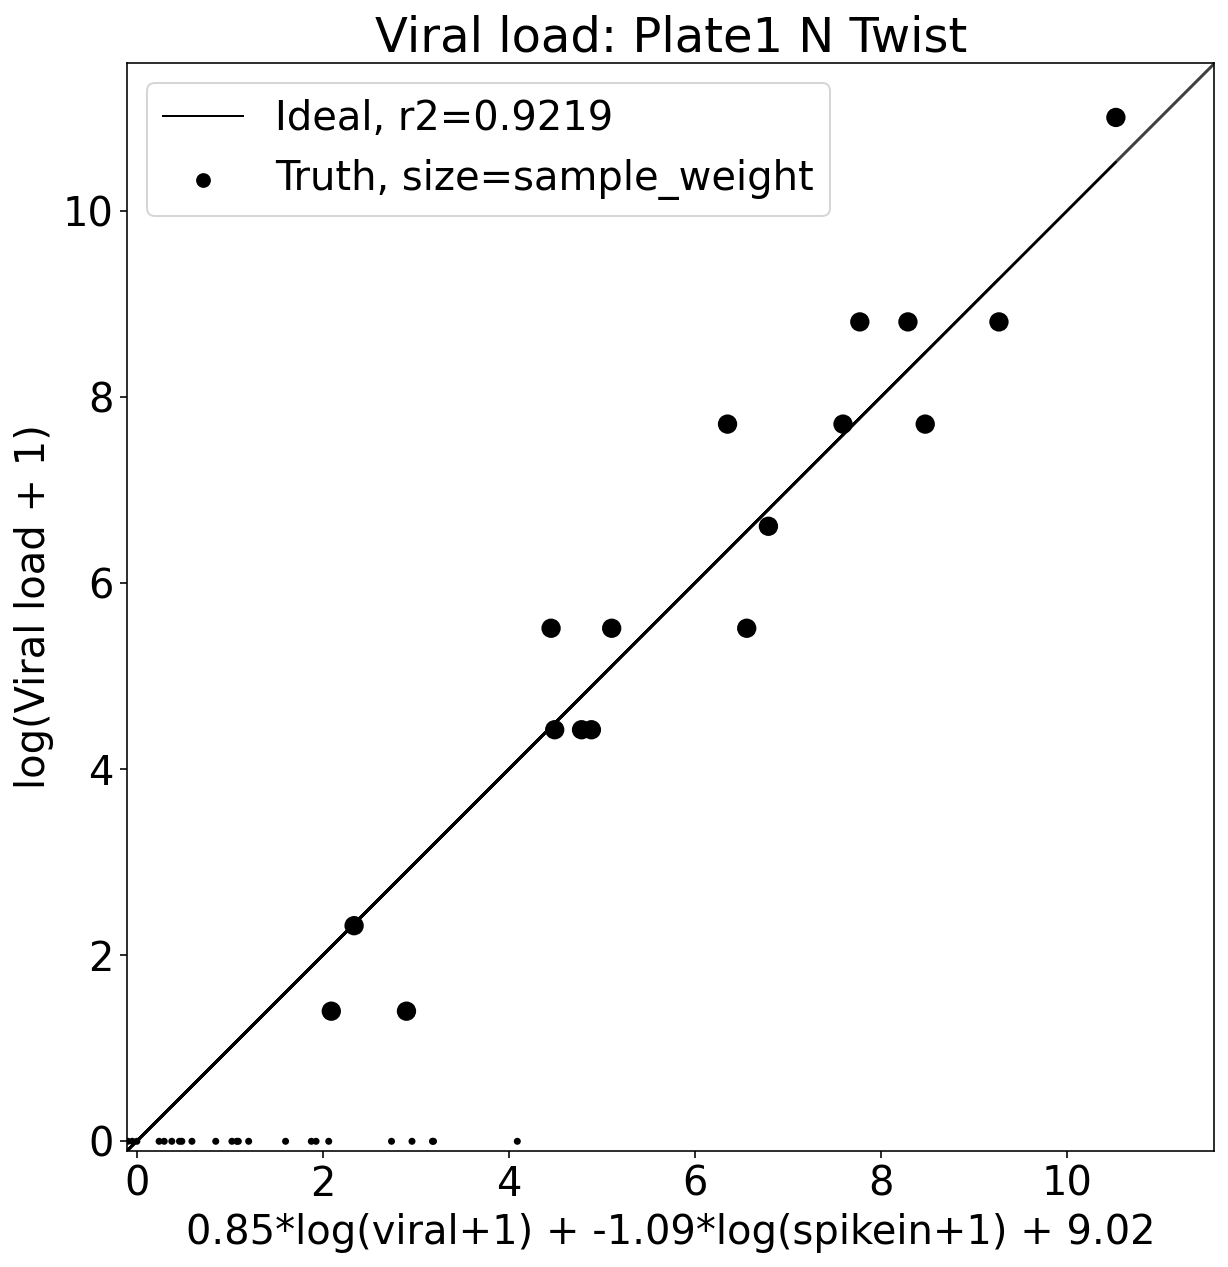

In [7]:
p, l, g, c = ("Plate1", "HEK293", "N1", "Twist")

pmask = obs.plate.values==p
cmask = obs[c+"_bool"].values
lmask = obs.lysate.values==l
gzero = obs[c].values>0

m = np.logical_and.reduce([pmask, cmask, lmask])#, gzero])
vm = np.logical_or.reduce([gene==g, gene==g+"_spikein"])

s_idx = np.where(gene==g+"_spikein")
v_idx = np.where(gene==g)


X = np.log1p(mtx[:,vm][m])

#X = np.log1p(mtx[m][:,vm])
load = np.log1p(obs[c].values[m])

f = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, load, test_size=f, random_state=43)

test_size = np.ceil(len(load)*f).astype(int)
train_size = X.shape[0]-test_size

print(test_size==y_test.shape[0])
print(train_size==y_train.shape[0])

sample_weight_train = np.ones(train_size)
sample_weight_train[y_train==0] = 1/np.unique(load).shape[0]

sample_weight_test = np.ones(test_size)
sample_weight_test[y_test==0] = 1/np.unique(load).shape[0]

lr = LinearRegression(normalize=False)

lr.fit(X_train, y_train, sample_weight=sample_weight_train)
y_pred = lr.predict(X_test)
print("r2 = {:,.4f}".format(lr.score(X_test, y_test, sample_weight=sample_weight_test)))

score = metrics.r2_score(y_test, y_pred, sample_weight=sample_weight_test)
mse = metrics.mean_squared_error(y_test, y_pred, sample_weight=sample_weight_test)
print("r2 coefficient    : {:,.4f}".format(score))
print('Mean squared error: {:,.4f}'.format(mse))

XX = np.dot(X_test, lr.coef_.T) + lr.intercept_

fig, ax = plt.subplots(figsize=(10,10))


ax.scatter(XX, y_test, label="Truth, size=sample_weight", s=sample_weight_test*75, c="k")
ax.plot(XX, y_pred, label="Ideal, r2={:,.4f}".format(score), color="k", linewidth=1)

ax.set_xlabel("{:,.2f}*log(viral+1) + {:,.2f}*log(spikein+1) + {:,.2f}".format(lr.coef_[0],lr.coef_[1], lr.intercept_))
ax.set_ylabel("log(Viral load + 1)")
ax.set_xlim(-0.1)
ax.set_ylim(-0.1)
yex(ax)

ax.set_title("Viral load: {} {} {}".format(p, g.split("_")[-1][0], c))
ax.legend()
# plt.savefig("./figs/viral_load_{}_{}_{}.png".format(p, g.split("_")[-1], c),bbox_inches='tight', dpi=300, fontsize=20)
plt.show()

True
True
r2 = 0.8341
r2 coefficient    : 0.8341
Mean squared error: 1.7287


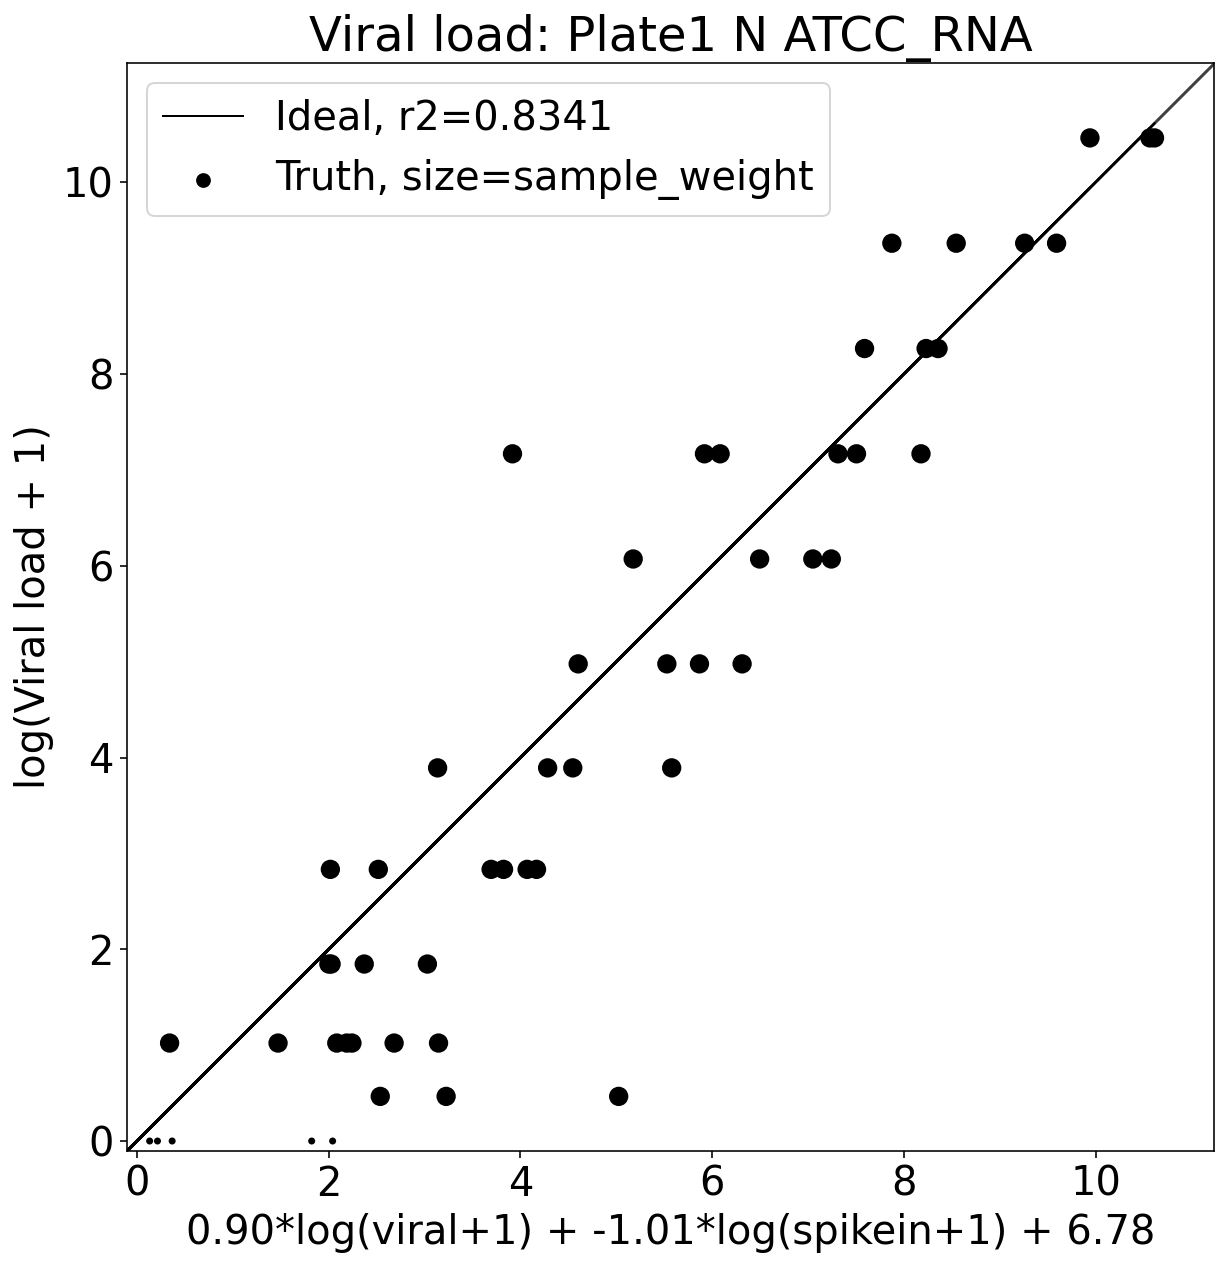

In [8]:
p, l, g, c = ("Plate1", "HEK293", "N1", "ATCC_RNA")

pmask = obs.plate.values==p
cmask = obs[c+"_bool"].values
lmask = obs.lysate.values==l
gzero = obs[c].values>0

m = np.logical_and.reduce([pmask, cmask, lmask])#, gzero])
vm = np.logical_or.reduce([gene==g, gene==g+"_spikein"])

s_idx = np.where(gene==g+"_spikein")
v_idx = np.where(gene==g)


X = np.log1p(mtx[:,vm][m])

#X = np.log1p(mtx[m][:,vm])
load = np.log1p(obs[c].values[m])

f = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, load, test_size=f, random_state=43)

test_size = np.ceil(len(load)*f).astype(int)
train_size = X.shape[0]-test_size

print(test_size==y_test.shape[0])
print(train_size==y_train.shape[0])

sample_weight_train = np.ones(train_size)
sample_weight_train[y_train==0] = 1/np.unique(load).shape[0]

sample_weight_test = np.ones(test_size)
sample_weight_test[y_test==0] = 1/np.unique(load).shape[0]

lr = LinearRegression(normalize=False)

lr.fit(X_train, y_train, sample_weight=sample_weight_train)
y_pred = lr.predict(X_test)
print("r2 = {:,.4f}".format(lr.score(X_test, y_test, sample_weight=sample_weight_test)))

score = metrics.r2_score(y_test, y_pred, sample_weight=sample_weight_test)
mse = metrics.mean_squared_error(y_test, y_pred, sample_weight=sample_weight_test)
print("r2 coefficient    : {:,.4f}".format(score))
print('Mean squared error: {:,.4f}'.format(mse))

XX = np.dot(X_test, lr.coef_.T) + lr.intercept_

fig, ax = plt.subplots(figsize=(10,10))


ax.scatter(XX, y_test, label="Truth, size=sample_weight", s=sample_weight_test*75, c="k")
ax.plot(XX, y_pred, label="Ideal, r2={:,.4f}".format(score), color="k", linewidth=1)

ax.set_xlabel("{:,.2f}*log(viral+1) + {:,.2f}*log(spikein+1) + {:,.2f}".format(lr.coef_[0],lr.coef_[1], lr.intercept_))
ax.set_ylabel("log(Viral load + 1)")
ax.set_xlim(-0.1)
ax.set_ylim(-0.1)
yex(ax)

ax.set_title("Viral load: {} {} {}".format(p, g.split("_")[-1][0], c))
ax.legend()
#plt.savefig("./figs/viral_load_{}_{}_{}.png".format(p, g.split("_")[-1], c),bbox_inches='tight', dpi=300, fontsize=20)
plt.show()

True
True
r2 = 0.9287
r2 coefficient    : 0.9287
Mean squared error: 0.7852


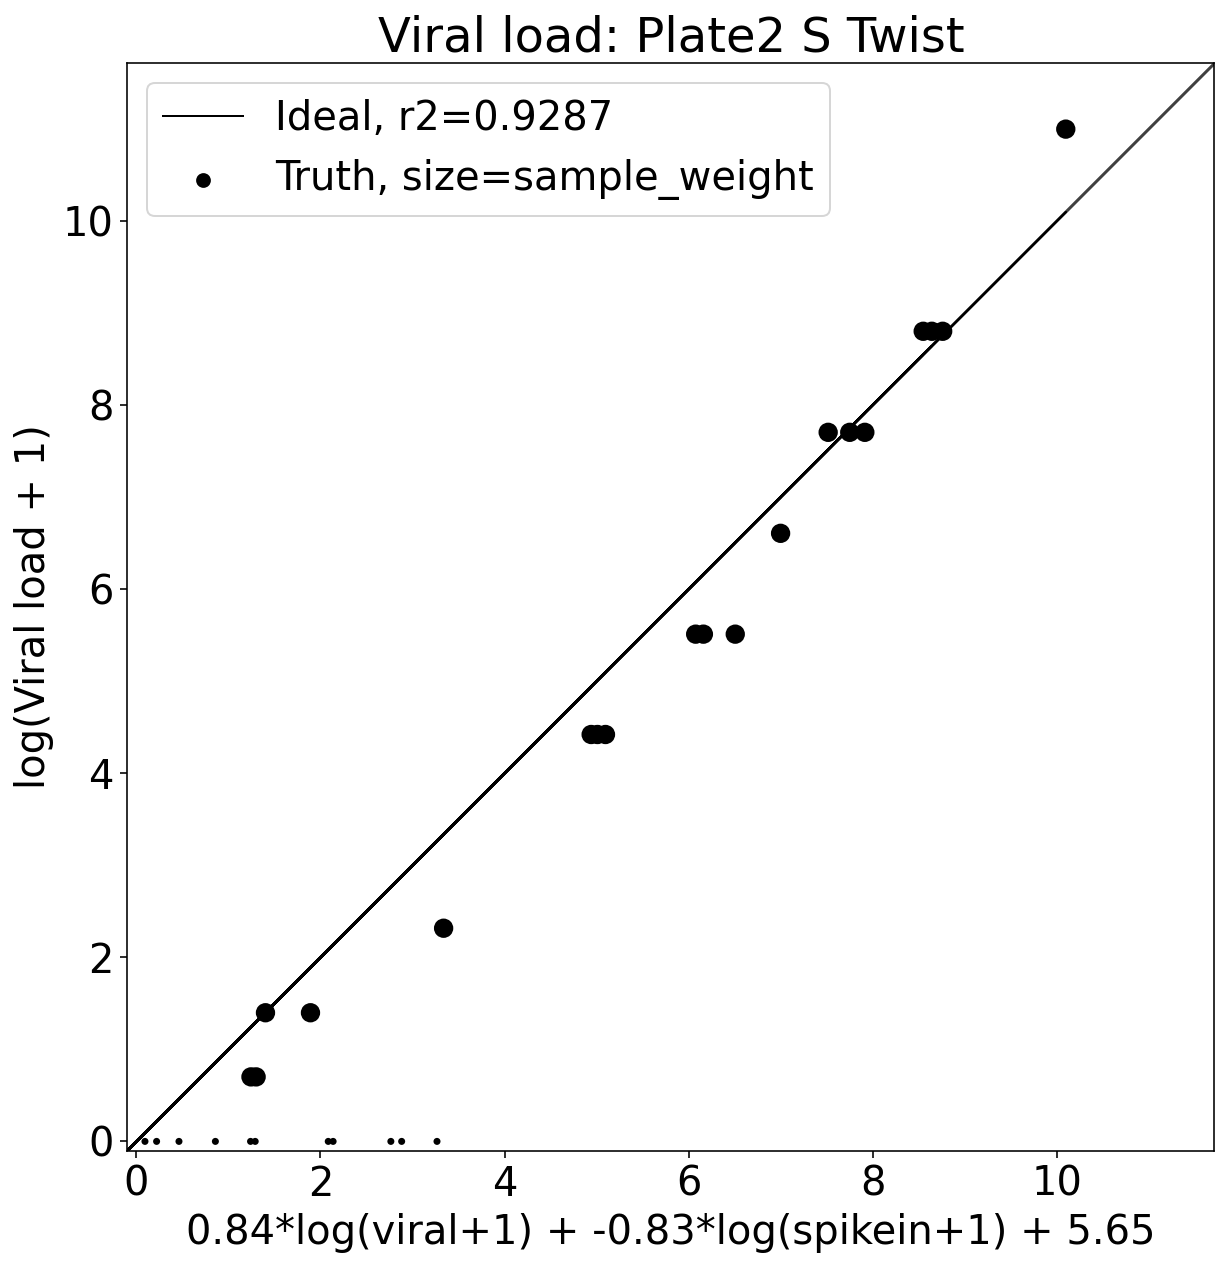

In [9]:
p, l, g, c = ("Plate2", "HEK293", "S2", "Twist")

pmask = obs.plate.values==p
cmask = obs[c+"_bool"].values
lmask = obs.lysate.values==l
gzero = obs[c].values>0

m = np.logical_and.reduce([pmask, cmask, lmask])#, gzero])
vm = np.logical_or.reduce([gene==g, gene==g+"_spikein"])

s_idx = np.where(gene==g+"_spikein")
v_idx = np.where(gene==g)


X = np.log1p(mtx[:,vm][m])

#X = np.log1p(mtx[m][:,vm])
load = np.log1p(obs[c].values[m])

f = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, load, test_size=f, random_state=43)

test_size = np.ceil(len(load)*f).astype(int)
train_size = X.shape[0]-test_size

print(test_size==y_test.shape[0])
print(train_size==y_train.shape[0])

sample_weight_train = np.ones(train_size)
sample_weight_train[y_train==0] = 1/np.unique(load).shape[0]

sample_weight_test = np.ones(test_size)
sample_weight_test[y_test==0] = 1/np.unique(load).shape[0]

lr = LinearRegression(normalize=False)

lr.fit(X_train, y_train, sample_weight=sample_weight_train)
y_pred = lr.predict(X_test)
print("r2 = {:,.4f}".format(lr.score(X_test, y_test, sample_weight=sample_weight_test)))

score = metrics.r2_score(y_test, y_pred, sample_weight=sample_weight_test)
mse = metrics.mean_squared_error(y_test, y_pred, sample_weight=sample_weight_test)
print("r2 coefficient    : {:,.4f}".format(score))
print('Mean squared error: {:,.4f}'.format(mse))

XX = np.dot(X_test, lr.coef_.T) + lr.intercept_

fig, ax = plt.subplots(figsize=(10,10))


ax.scatter(XX, y_test, label="Truth, size=sample_weight", s=sample_weight_test*75, c="k")
ax.plot(XX, y_pred, label="Ideal, r2={:,.4f}".format(score), color="k", linewidth=1)

ax.set_xlabel("{:,.2f}*log(viral+1) + {:,.2f}*log(spikein+1) + {:,.2f}".format(lr.coef_[0],lr.coef_[1], lr.intercept_))
ax.set_ylabel("log(Viral load + 1)")
ax.set_xlim(-0.1)
ax.set_ylim(-0.1)
yex(ax)

ax.set_title("Viral load: {} {} {}".format(p, g.split("_")[-1][0], c))
ax.legend()
#plt.savefig("./figs/viral_load_{}_{}_{}.png".format(p, g.split("_")[-1], c),bbox_inches='tight', dpi=300, fontsize=20)
plt.show()

True
True
r2 = 0.8390
r2 coefficient    : 0.8390
Mean squared error: 1.6783


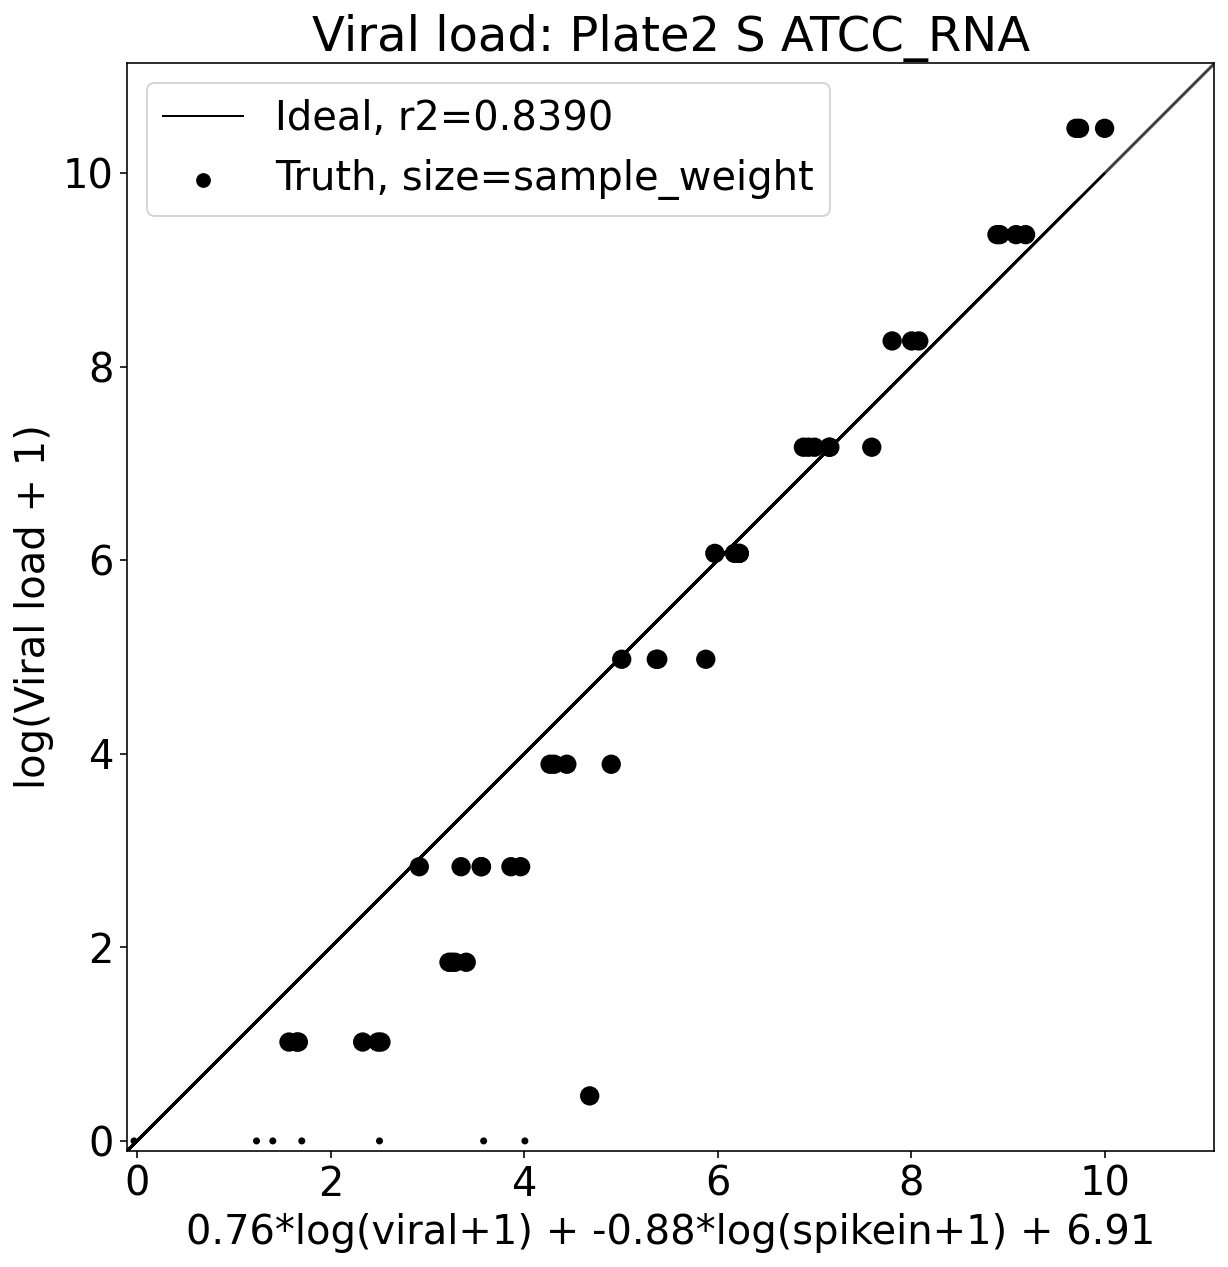

In [10]:
p, l, g, c = ("Plate2", "HEK293", "S2", "ATCC_RNA")

pmask = obs.plate.values==p
cmask = obs[c+"_bool"].values
lmask = obs.lysate.values==l
gzero = obs[c].values>0

m = np.logical_and.reduce([pmask, cmask, lmask])#, gzero])
vm = np.logical_or.reduce([gene==g, gene==g+"_spikein"])

s_idx = np.where(gene==g+"_spikein")
v_idx = np.where(gene==g)


X = np.log1p(mtx[:,vm][m])

#X = np.log1p(mtx[m][:,vm])
load = np.log1p(obs[c].values[m])

f = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, load, test_size=f, random_state=43)

test_size = np.ceil(len(load)*f).astype(int)
train_size = X.shape[0]-test_size

print(test_size==y_test.shape[0])
print(train_size==y_train.shape[0])

sample_weight_train = np.ones(train_size)
sample_weight_train[y_train==0] = 1/np.unique(load).shape[0]

sample_weight_test = np.ones(test_size)
sample_weight_test[y_test==0] = 1/np.unique(load).shape[0]

lr = LinearRegression(normalize=False)

lr.fit(X_train, y_train, sample_weight=sample_weight_train)
y_pred = lr.predict(X_test)
print("r2 = {:,.4f}".format(lr.score(X_test, y_test, sample_weight=sample_weight_test)))

score = metrics.r2_score(y_test, y_pred, sample_weight=sample_weight_test)
mse = metrics.mean_squared_error(y_test, y_pred, sample_weight=sample_weight_test)
print("r2 coefficient    : {:,.4f}".format(score))
print('Mean squared error: {:,.4f}'.format(mse))

XX = np.dot(X_test, lr.coef_.T) + lr.intercept_

fig, ax = plt.subplots(figsize=(10,10))


ax.scatter(XX, y_test, label="Truth, size=sample_weight", s=sample_weight_test*75, c="k")
ax.plot(XX, y_pred, label="Ideal, r2={:,.4f}".format(score), color="k", linewidth=1)

ax.set_xlabel("{:,.2f}*log(viral+1) + {:,.2f}*log(spikein+1) + {:,.2f}".format(lr.coef_[0],lr.coef_[1], lr.intercept_))
ax.set_ylabel("log(Viral load + 1)")
ax.set_xlim(-0.1)
ax.set_ylim(-0.1)
yex(ax)

ax.set_title("Viral load: {} {} {}".format(p, g.split("_")[-1][0], c))
ax.legend()
#plt.savefig("./figs/viral_load_{}_{}_{}.png".format(p, g.split("_")[-1], c),bbox_inches='tight', dpi=300, fontsize=20)
plt.show()